This is the main script for the training and testing of the shallowCNN model,
used for the classification of abnormal EEG activity.

## Import Packages

In [1]:
import import_ipynb
import numpy as np
from PreProcessing import import_tuh_abnormal, create_ch_mapping
from DataTransform import data_transform, train_valid_test_split, get_parameters_for_model
import torch
from braindecode.preprocessing import preprocess, Preprocessor, scale as multiply
from braindecode.util import set_random_seeds
from braindecode.models import ShallowFBCSPNet, Deep4Net
from torch import optim
from Models import create_model
from TrainingValidationTesting_CNNs import train_model, test_model
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, RocCurveDisplay
import matplotlib.pyplot as plt


importing Jupyter notebook from PreProcessing_v1.ipynb
importing Jupyter notebook from DataTransform.ipynb
importing Jupyter notebook from Models.ipynb
importing Jupyter notebook from TransformFunction.ipynb


## Import TUH Abnormal Dataset

In [2]:

TUH_PATH = 'TUH EEG Abnormal dataset/Abnormal/' # specify the path to the TUH Abnormal dataset
N_JOBS = 32  # specify the number of jobs for loading and windowing

# Parameters to be defined for the preprocessing pipeline
TMIN = 1 * 60
TMAX = 2 * 60 
SFREQ = 100
CLIPPING = 800

tuh_abnormal = import_tuh_abnormal(TUH_PATH, N_JOBS)

In [4]:
# Create short channel names and mapping    
short_ch_names, ch_mapping = create_ch_mapping()

def select_by_channels(ds, short_ch_names, ch_mapping):
    split_ids = []
    for i, d in enumerate(ds.datasets):
        ref = 'ar' if d.raw.ch_names[0].endswith('-REF') else 'le'
        # these are the channels we are looking for
        seta = set(ch_mapping[ref].keys())
        # these are the channels of the recoding
        setb = set(d.raw.ch_names)
        # if recording contains all channels we are looking for, include it
        if seta.issubset(setb):
            split_ids.append(i)
    return ds.split(split_ids)['0']


def custom_crop(raw, tmin=0.0, tmax=None, include_tmax=True):
    # crop recordings to tmin – tmax. can be incomplete if recording
    # has lower duration than tmax
    # by default mne fails if tmax is bigger than duration
    tmax = min((raw.n_times - 1) / raw.info['sfreq'], tmax)
    raw.crop(tmin=tmin, tmax=tmax, include_tmax=include_tmax)
    
    
def custom_rename_channels(raw, mapping):
    # rename channels which are dependent on referencing:
    # le: EEG 01-LE, ar: EEG 01-REF
    # mne fails if the mapping contains channels as keys that are not present
    # in the raw
    reference = raw.ch_names[0].split('-')[-1].lower()
    assert reference in ['le', 'ref'], 'unexpected referencing'
    reference = 'le' if reference == 'le' else 'ar'
    raw.rename_channels(mapping[reference])
    
short_ch_names, ch_mapping = create_ch_mapping()

preprocessors = [
        Preprocessor(custom_crop, tmin=TMIN, tmax=TMAX, include_tmax=True,
                     apply_on_array=False),
        Preprocessor('set_eeg_reference', ref_channels='average', ch_type='eeg'), # mne Raw class function
        Preprocessor(custom_rename_channels, mapping=ch_mapping, # rename channels to short channel names
                     apply_on_array=False), #
        Preprocessor('pick_channels', ch_names=short_ch_names, ordered=True), # mne Raw class function
        Preprocessor(multiply, factor=1e6, apply_on_array=True), # scaling signals to microvolt
        Preprocessor(np.clip, a_min=-CLIPPING, a_max=CLIPPING, apply_on_array=True), # clip outlier values to +/- 800 micro volts
        Preprocessor('resample', sfreq=SFREQ), # mne Raw class function
    ]

tuh_preproc = preprocess(
        concat_ds=tuh_abnormal,
        preprocessors=preprocessors,
        n_jobs=N_JOBS,
        save_dir=None
    )


## Data Transform and Instantiate Model

In [6]:
# Execute train-validation-test split

TRAIN_SIZE=0.9 # Parameter for defining the ratio of training set (remainder defines the size of the validation set)

tuh_train, tuh_val, tuh_test = train_valid_test_split(tuh_preproc, train_size=TRAIN_SIZE)

In [8]:
cuda = torch.cuda.is_available()  # check if GPU is available, if True, use it
device = 'cuda' if cuda else 'cpu'
if cuda:
    torch.backends.cudnn.benchmark = True

seed = 20200220
set_random_seeds(seed=seed, cuda=cuda)

# Required parameters for model creation
INPUT_WIN_SAMPLES = 6000
INC_CHANS, INPUT_SIZE_SAMPLES = get_parameters_for_model(tuh_train)
N_CLASSES = 2
MODEL_NAME = "shallow" # it can either be shallow, deep, or hybrid
FINAL_CONV_LENGTH = 25

model = create_model(MODEL_NAME, INC_CHANS, N_CLASSES, INPUT_WIN_SAMPLES, FINAL_CONV_LENGTH)


# If available, use multiple GPUs for training and testing
if cuda:
    device = "cuda:0"
    if torch.cuda.device_count() > 1:
        model = torch.nn.DataParallel(model)
model.to(device)
    
    

ShallowFBCSPNet(
  (ensuredims): Ensure4d()
  (dimshuffle): Expression(expression=transpose_time_to_spat) 
  (conv_time): Conv2d(1, 40, kernel_size=(25, 1), stride=(1, 1))
  (conv_spat): Conv2d(40, 40, kernel_size=(1, 21), stride=(1, 1), bias=False)
  (bnorm): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_nonlin_exp): Expression(expression=square) 
  (pool): AvgPool2d(kernel_size=(75, 1), stride=(15, 1), padding=0)
  (pool_nonlin_exp): Expression(expression=safe_log) 
  (drop): Dropout(p=0.5, inplace=False)
  (conv_classifier): Conv2d(40, 2, kernel_size=(25, 1), stride=(1, 1))
  (softmax): LogSoftmax(dim=1)
  (squeeze): Expression(expression=squeeze_final_output) 
)

In [9]:
# Execute DataLoader generating function

BATCH_SIZE=64

train_loader, val_loader, test_loader = data_transform(tuh_train, tuh_val, tuh_test, model, N_JOBS, train_size=TRAIN_SIZE, batch_size=BATCH_SIZE, input_window_samples=INPUT_WIN_SAMPLES, in_chans = INC_CHANS)

In [12]:
# Hyperparameters required for the training of the model

lr =  0.01
optimizer = optim.Adam(params=model.parameters(), lr=lr)
criterion = torch.nn.NLLLoss()
# criterion = torch.nn.BCELoss()
n_epochs = 35  
patience = 10


In [13]:
# Model training

trained_model, train_losses, train_accs, valid_losses, valid_accs = train_model(model, device, criterion, optimizer, train_loader, val_loader, n_epochs, patience)
trained_model.to(device)

Time: 05/11/2022, 11:23:11. . [1/35, 2/39] train_loss: 4.10988, train_acc: 0.303
Time: 05/11/2022, 11:23:14. . [1/35, 4/39] train_loss: 2.51928, train_acc: 0.305
Time: 05/11/2022, 11:23:18. . [1/35, 6/39] train_loss: 2.90031, train_acc: 0.351
Time: 05/11/2022, 11:23:21. . [1/35, 8/39] train_loss: 2.92495, train_acc: 0.391
Time: 05/11/2022, 11:23:24. . [1/35, 10/39] train_loss: 2.52454, train_acc: 0.419
Time: 05/11/2022, 11:23:28. . [1/35, 12/39] train_loss: 2.2175, train_acc: 0.441
Time: 05/11/2022, 11:23:31. . [1/35, 14/39] train_loss: 2.01663, train_acc: 0.457
Time: 05/11/2022, 11:23:34. . [1/35, 16/39] train_loss: 1.86052, train_acc: 0.468
Time: 05/11/2022, 11:23:37. . [1/35, 18/39] train_loss: 1.73047, train_acc: 0.475
Time: 05/11/2022, 11:23:40. . [1/35, 20/39] train_loss: 1.66241, train_acc: 0.482
Time: 05/11/2022, 11:23:43. . [1/35, 22/39] train_loss: 1.57063, train_acc: 0.487
Time: 05/11/2022, 11:23:47. . [1/35, 24/39] train_loss: 1.50309, train_acc: 0.491
Time: 05/11/2022, 11:

In [ ]:
# Save the trained model

PATH = './modelname.pth'
torch.save(model.state_dict(), PATH)

In [14]:
#  Model testing

x_test, y_test, y_pred, accuracy = test_model(device, trained_model, test_loader)

Accuracy: 0.671


## Evaluation Metrics

In [16]:
# Reshape tensors

x_test = x_test.flatten().cpu()
y_test = y_test.flatten().cpu()
y_pred = y_pred.flatten().cpu()

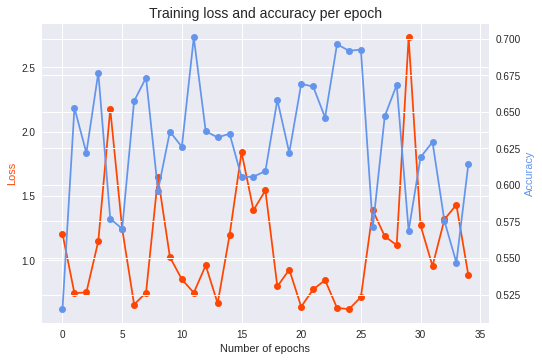

In [18]:
# Training loss and accuracy per epoch

fig,ax = plt.subplots()
ax.plot(train_losses, marker="o", color="orangered", label="Training loss")
ax.set_xlabel("Number of epochs")
ax.set_ylabel("Loss", color="orangered")

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
ax2.plot(train_accs, marker="o", color="cornflowerblue", label="Training accuracy")
ax2.set_ylabel("Accuracy", color="cornflowerblue")

plt.title("Training loss and accuracy per epoch", fontsize=14)
plt.show()


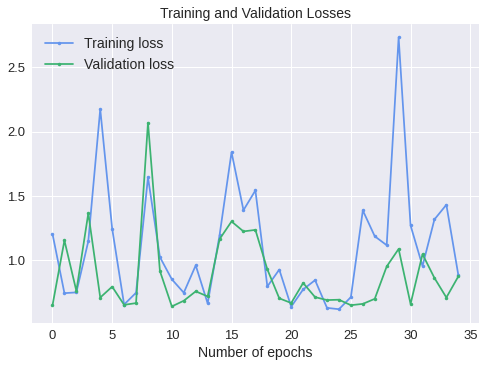

In [30]:
# Learning curve with training and validation loss

ax = plt.axes()
plt.plot(train_losses, marker=".", color="cornflowerblue", label='Training loss')
plt.plot(valid_losses, marker=".", color="mediumseagreen", label='Validation loss')
plt.title('Training and Validation Losses', fontsize=14)
plt.xlabel('Number of epochs', fontsize=14)
plt.legend(frameon=False, fontsize=14)
ax.tick_params(axis='both', labelsize=13)
plt.show()

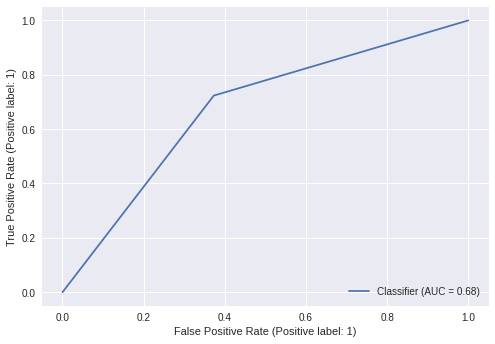

In [31]:
''' 
The ROC Curve plots two parameters: the True Positive Rate (TPR), a synonim to recall,
and the False Positive Rate (FPR). 
The plot also shows the ROC AUC score.
By default, the class considered as the positive (It means Abnormal in our case).

'''

RocCurveDisplay.from_predictions(y_test, y_pred, pos_label=None)
plt.show()

In [32]:
# Confusion matrix and Classification Report

conf_matrix = confusion_matrix(y_test, y_pred)
cl_report = classification_report(y_test, y_pred)

print(cl_report)

              precision    recall  f1-score   support

         0.0       0.73      0.63      0.67     55500
         1.0       0.62      0.72      0.67     46620

    accuracy                           0.67    102120
   macro avg       0.67      0.68      0.67    102120
weighted avg       0.68      0.67      0.67    102120



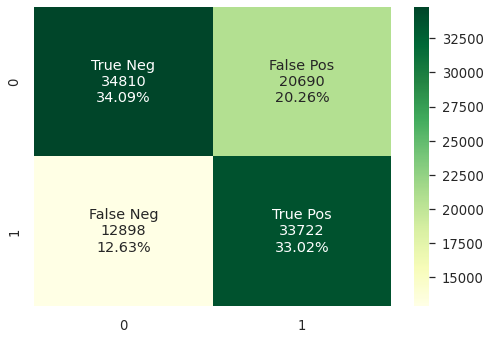

In [39]:
# Confusion matrix plot

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                conf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     conf_matrix.flatten()/np.sum(conf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)


sns.heatmap(conf_matrix, annot=labels, fmt='', cmap='YlGn')
sns.set(font_scale=0.5)
ax.set_title('Confusion Matrix', fontsize=16)
ax.set_xlabel('Predicted labels', fontsize=14)
ax.set_ylabel('True labels', fontsize=14)
ax.tick_params(axis='both', labelsize=13)
plt.show()